In [1]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Загрузим 'titanic.csv'

In [2]:
df = pd.read_csv('titanic.csv', index_col='PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Проанализируем имеющиеся данные

1. Зависимость выживания от параметров Sex, Pclass, Fare


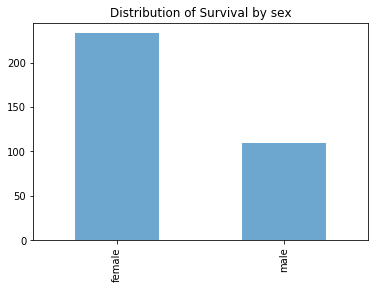

In [4]:
print('1. Зависимость выживания от параметров Sex, Pclass, Fare')
    
alpha_level = 0.65
    
# Sex
df_sex_survived = df.Sex[df.Survived == 1].value_counts()
df_sex_survived.plot(kind='bar', alpha=alpha_level)
plt.title("Distribution of Survival by sex")
plt.show()

Мы видим, что для пассажира женского пола вероятность выжить была выше, чем у пассажира мужского пола. Значит признак пола значим для классификации.

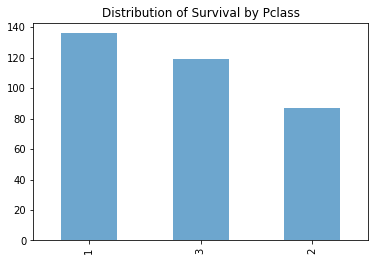

In [5]:
# Pclass
df_pclass_survived = df.Pclass[df.Survived == 1].value_counts()
df_pclass_survived.plot(kind='bar', alpha=alpha_level)
plt.title("Distribution of Survival by Pclass")
plt.show()

Мы видим, что для пассажира первого класса вероятность выжить была выше, чем у пассажира второго класса. 
Для пассажира второго класса вероятность выжить была выше, чем у пассажира первого класса. Заметим однако, что разница между вероятностями не настолько хорошо выражена, как у пола.

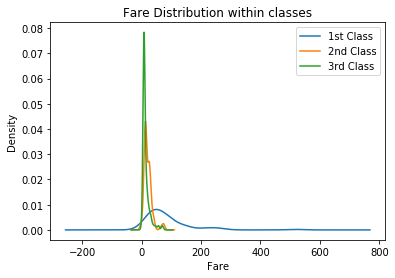

In [6]:
# Fares
df.Fare[df.Pclass == 1].plot(kind='kde')
df.Fare[df.Pclass == 2].plot(kind='kde')
df.Fare[df.Pclass == 3].plot(kind='kde')
plt.xlabel("Fare")
plt.title("Fare Distribution within classes")
plt.legend(('1st Class', '2nd Class', '3rd Class'), loc='best')
plt.show()

2. Гистограмма, описывающая среднюю вероятность выжить в зависимости от пола и соц. статуса


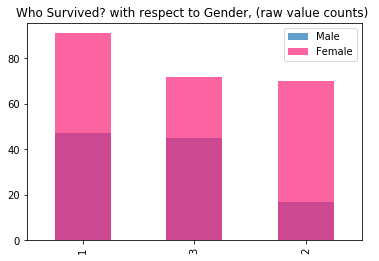

In [7]:
print('2. Гистограмма, описывающая среднюю вероятность выжить в зависимости от пола и соц. статуса')

df_male = df.Pclass[df.Sex == 'male'][df.Survived == 1].value_counts()       # выживших мужчин
df_female = df.Pclass[df.Sex == 'female'][df.Survived == 1].value_counts()   # выживших женщин

df_male.plot(kind='bar', label='Male', alpha=0.70)
df_female.plot(kind='bar', color='#FA2379', label='Female', alpha=0.70)
plt.title("Who Survived? with respect to Gender, (raw value counts) ")
plt.legend(('Male', 'Female'), loc='best')
plt.show()

- У пассажира женского пола первого класса самая высокая вероятность выжить. 
- У женщин первого и второго класса вероятности выжить больше чем у мужчин их же класса. 
- У мужчин и женщин третьего класса примерно одинаковая вероятность выжить.

P(выжить|женщина, 1 класс) > P(выжить|мужчина, 1 класс)

P(выжить,женщина) > P(выжить, мужчина)

## Очистим данные и сформируем датасет

In [8]:
train = pd.read_csv('titanic.csv', index_col='PassengerId')
train.head(8)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


In [9]:
def missing(data):
    
    # Заменим пропуски в Age на медиану...
    median_age = data['Age'].median()
    data['Age'].fillna(value=median_age, inplace=True)
    
    # Заменим пропуски в Fare на медиану...
    median_fare = data['Fare'].median()
    data['Fare'].fillna(value=median_fare, inplace=True)

    # Заменим пропуски в Embarked
    mode_embarked = data['Embarked'].mode()[0]
    data['Embarked'].fillna(value=mode_embarked, inplace=True)
    
    # Создадим две новые категории. Можно предположить, что то, является ли человек одиночкой, 
    # и есть ли у него какие-то родственники может сыграть какую-нибудь роль
    data['Relatives'] = data["Parch"] + data["SibSp"]  # сколько всего родственников у человека
    data['Single'] = data["Relatives"].apply(lambda r: 1 if r == 0 else 0)   # является ли человек одиночкой
    
    # Дропнем ненужное
    data = data.drop(['Name','Cabin','Ticket'], 1) 

    data.head(8)
    return data

In [10]:
train = missing(train)
train.head(8)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Relatives,Single
PassengerId,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,1,0
2,1,1,female,38.0,1,0,71.2833,C,1,0
3,1,3,female,26.0,0,0,7.9250,S,0,1
4,1,1,female,35.0,1,0,53.1000,S,1,0
5,0,3,male,35.0,0,0,8.0500,S,0,1
6,0,3,male,28.0,0,0,8.4583,Q,0,1
7,0,1,male,54.0,0,0,51.8625,S,0,1
8,0,3,male,2.0,3,1,21.0750,S,4,0


In [11]:
# Переводим categorical в numerical
train = pd.get_dummies(train, drop_first=True)
train.head(8)

,Survived,Pclass,Age,SibSp,Parch,Fare,Relatives,Single,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,1,0,1,0,1
2,1,1,38.0,1,0,71.2833,1,0,0,0,0
3,1,3,26.0,0,0,7.9250,0,1,0,0,1
4,1,1,35.0,1,0,53.1000,1,0,0,0,1
5,0,3,35.0,0,0,8.0500,0,1,1,0,1
6,0,3,28.0,0,0,8.4583,0,1,1,1,0
7,0,1,54.0,0,0,51.8625,0,1,1,0,1
8,0,3,2.0,3,1,21.0750,4,0,1,0,1


In [12]:
x_labels = ['Pclass', 'Age', 'Fare', 'Relatives', 'Single', 'Sex_male', 'Embarked_Q', 'Embarked_S'] 

In [13]:
X, y = train[x_labels], train['Survived']

## Проанализируем параметры и подберем наиболее удачный:

In [14]:
selector = SelectKBest(f_classif, k=5)
selector.fit(X, y)

SelectKBest(k=5, score_func=<function f_classif at 0x1115b1400>)

In [15]:
scores = -np.log10(selector.pvalues_)

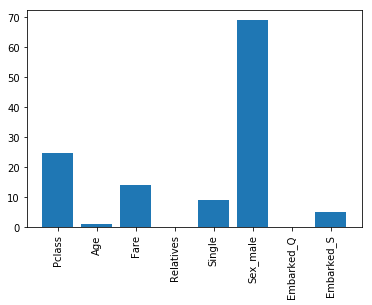

In [16]:
plt.bar(range(len(x_labels)), scores)
plt.xticks(range(len(x_labels)), x_labels, rotation='vertical')
plt.show()

Из графиков видно, что пол, класс играют важную роль в решении того, выживет ли человек. Можно также предположить,
что наличие семьи тоже играет положительную роль при принятии решении о том, кого посадить вместе

#### Посмотрим еще на importances

In [17]:
dt_clf = DecisionTreeClassifier(random_state=42)

In [18]:
dt_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [19]:
importances = pd.Series(dt_clf.feature_importances_, index=x_labels)

In [20]:
importances

Pclass        0.110417
Age           0.229636
Fare          0.239887
Relatives     0.081456
Single        0.009415
Sex_male      0.310881
Embarked_Q    0.006767
Embarked_S    0.011541
dtype: float64

In [21]:
rf_clf = RandomForestClassifier()

In [22]:
rf_clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [23]:
importances = pd.Series(rf_clf.feature_importances_, index=x_labels)

In [24]:
importances

Pclass        0.096429
Age           0.268827
Fare          0.271634
Relatives     0.057113
Single        0.015190
Sex_male      0.259282
Embarked_Q    0.006029
Embarked_S    0.025496
dtype: float64

Мы видим, что большой вес имеет Sex_male, Age и Fare. Самый маленький вес имеет Embarked_Q

## Разделим данные на тестовую и обучающую выборку и посмотрим на параметры моделей DecisionTreeClassifier и RandomForest

In [25]:
# Удалим параметры, играющие небольшую роль
x_labels = ['Pclass', 'Age', 'Fare', 'Relatives', 'Sex_male', 'Embarked_S'] 
X, y = train[x_labels], train['Survived']

In [26]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3)

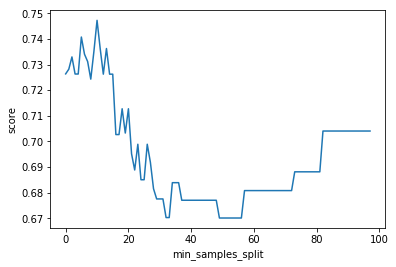

In [33]:
# Выборать наиболее удачный параметр и нарисовать в зависимости от этого дерево
scores = []
for t in range(2, 100):
    dt_clf = DecisionTreeClassifier(min_samples_split=t)
    dt_clf.fit(X_train, y_train)
    y_pred = dt_clf.predict(X_test)
    scores.append(f1_score(y_test, y_pred))
    
plt.plot(scores)
plt.xlabel('min_samples_split')
plt.ylabel('score')
plt.show()

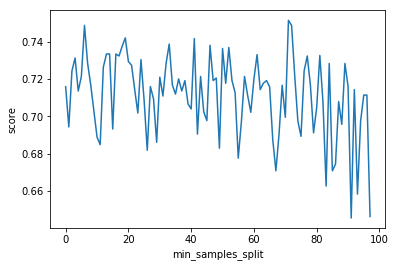

In [34]:
# Выборать наиболее удачный параметр и нарисовать в зависимости от этого дерево
scores = []
for t in range(2, 100):
    rf_clf = RandomForestClassifier(min_samples_split=t)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    scores.append(f1_score(y_test, y_pred))
    
plt.plot(scores)
plt.xlabel('min_samples_split')
plt.ylabel('score')
plt.show()

## Перебор параметров с помощью GridSearchCV и обучение DecisionTreeClassifier и RandomForest

In [35]:
def grid_search_function(clf, parameters, X_train, X_test, y_train, y_test):
    gs = GridSearchCV(clf, parameters)
    gs.fit(X_train, y_train)
    print (gs.best_params_)
    y_pred = gs.predict(X_test)
    print(classification_report(y_test, y_pred))

In [36]:
dt_params = {
              'max_depth':[None, 3, 4, 5, 6, 10],
              'max_leaf_nodes':[None, 6, 8, 10, 12, 14],
              'min_samples_leaf': [3, 5, 7, 10]
             }

In [37]:
grid_search_function(DecisionTreeClassifier(random_state=42), dt_params, X_train, X_test, y_train, y_test)

{'min_samples_leaf': 7, 'max_depth': None, 'max_leaf_nodes': 14}
             precision    recall  f1-score   support

          0       0.81      0.88      0.85       170
          1       0.76      0.64      0.70        98

avg / total       0.79      0.79      0.79       268



In [38]:
rf_params = {
              'n_estimators': [50, 65, 70, 75],
              'max_depth':[None, 6, 8, 10, 12],
              'max_leaf_nodes':[None, 6, 8, 10, 12],
              'min_samples_leaf': [2, 3, 4]
             }

In [39]:
grid_search_function(RandomForestClassifier(), rf_params, X_train, X_test, y_train, y_test)

{'min_samples_leaf': 3, 'max_depth': 10, 'max_leaf_nodes': 12, 'n_estimators': 50}
             precision    recall  f1-score   support

          0       0.82      0.92      0.87       170
          1       0.83      0.64      0.72        98

avg / total       0.82      0.82      0.82       268



Мы видим, что DecisionTreeClassifier и RandomForestClassifier справляются с задачей классификации с примерно одинаковых успехом, оба достаточно хорошо. RandomForestClassifier справляется немного лучше